In [5]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Dataset Paths 
train_dir = r"C:\Users\PC\Downloads\TS Recommended Apps\work\file2\dataset_split\train"
val_dir = r"C:\Users\PC\Downloads\TS Recommended Apps\work\file2\dataset_split\val"

In [ ]:
# Check if dataset exists
if not os.path.exists(train_dir):
    print(f"ERROR: Train directory not found: {train_dir}")
    sys.exit(1)

if not os.path.exists(val_dir):
    print(f"ERROR: Validation directory not found: {val_dir}")
    sys.exit(1)

print(" Dataset paths found!")
print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))

✅ Dataset paths found!
Train classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Validation classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Create datasets & dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f" Train dataset size: {len(train_dataset)}")
print(f" Validation dataset size: {len(val_dataset)}")

✅ Train dataset size: 3769
✅ Validation dataset size: 943


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# Load pretrained ResNet50
num_classes = len(train_dataset.classes)
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:03<00:00, 1.62MB/s]


In [ ]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    #Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    #Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / total
    val_acc = correct / total
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.5458, Train Acc: 0.8220
Val Loss: 0.3341, Val Acc: 0.8929

Epoch 2/10
Train Loss: 0.2136, Train Acc: 0.9326
Val Loss: 0.4072, Val Acc: 0.8780

Epoch 3/10
Train Loss: 0.1238, Train Acc: 0.9591
Val Loss: 0.3387, Val Acc: 0.9003

Epoch 4/10
Train Loss: 0.1100, Train Acc: 0.9660
Val Loss: 0.3706, Val Acc: 0.8918

Epoch 5/10
Train Loss: 0.0792, Train Acc: 0.9753
Val Loss: 0.3686, Val Acc: 0.8971

Epoch 6/10
Train Loss: 0.0753, Train Acc: 0.9751
Val Loss: 0.4338, Val Acc: 0.8834

Epoch 7/10
Train Loss: 0.0541, Train Acc: 0.9849
Val Loss: 0.3527, Val Acc: 0.9003

Epoch 8/10
Train Loss: 0.0466, Train Acc: 0.9851
Val Loss: 0.4149, Val Acc: 0.9024

Epoch 9/10
Train Loss: 0.0641, Train Acc: 0.9788
Val Loss: 0.4163, Val Acc: 0.8940

Epoch 10/10
Train Loss: 0.0578, Train Acc: 0.9809
Val Loss: 0.3889, Val Acc: 0.9046


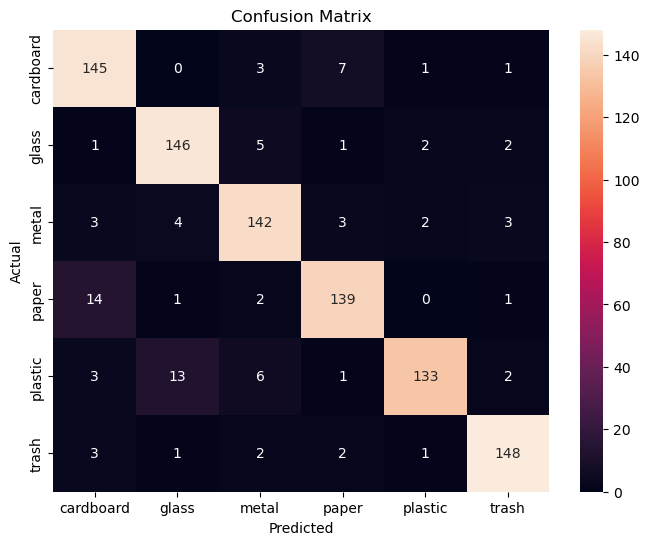

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report (Precision, Recall, F1-score)
print("\n===== Classification Report =====")
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)


===== Classification Report =====
              precision    recall  f1-score   support

   cardboard       0.86      0.92      0.89       157
       glass       0.88      0.93      0.91       157
       metal       0.89      0.90      0.90       157
       paper       0.91      0.89      0.90       157
     plastic       0.96      0.84      0.90       158
       trash       0.94      0.94      0.94       157

    accuracy                           0.90       943
   macro avg       0.91      0.90      0.90       943
weighted avg       0.91      0.90      0.90       943



In [ ]:
# Save the trained model
torch.save(model.state_dict(), "resnet50_waste_classifier.pth")
print(" Model saved as resnet50_waste_classifier.pth")

✅ Model saved as resnet50_waste_classifier.pth
